# Snapshot Graphs
Transmission graphs for an integration. Cleaning WIP

In [3]:
from AD_analysis import *
import Atmospheric_diffraction as atm_shift
import numpy as np

The code mainly draws on the following steps, with key variables described:

>analysis=AD_analysis()

This gets the class

====
>analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm) 

This function loads the wavelengths that will be used for the shift calculations. 

First variable is LR or HR

Second variable is NIR or VIS

Third/fourth variables are the start/end bands. These can be the same, e.g. 'B', 'B'.

====
>analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])

OR
>analysis.load_airmasses(HA_range=[0,1,2],targ_dec= 0 * u.degree)
This function loads the airmasses to calculate the shifts for.

Can use 1) zenith angles (ZA_range)
OR 2) hour angles (HA_range); the declination is -25.3 deg by default, change with targ_dec=X

====
>analysis.calculate_shifts(fibrecentre_waveref = 1.1 * u.micron,reposition=True, guide_waveref=5 * u.micron)

This function calculates the shifts for the generated wavelengths and airmasses

fibrecentre_waveref is the aperture wavelength reference for original position

guide_waveref is the telescope guiding wavelength reference

reposition = TRUE or FALSE is a setting that determines whether the fibre is aligned on the aperture wavelength reference for each sequential airmass

====
>analysis.calculate_transmissions(method="numerical moffat") 

This function calculates the transmissions for the shifts using one of several methods

method can be 1) analytical gaussian, 2) numerical gaussian, 3) numerical moffat, or 4) numerical durham

====

These functions can be used in many ways for different plots/analysis of transmissions/shifts

Most of these function have other optional variables, e.g., scale for the numerical simulations, whether to change FWHM with airmass and wavelength. These are described in the relevant function notes

In [4]:
#This function is used to calculate the average transmission over an integration.
#It takes the transmissions for each wavelength from multiple airmasses and averages them.
#This only is a true average of an integration if equally spaced HA have been used.
#This is not true with ZA, as ZA does not increase linearly with time
def observation_transmission(output_parameters):
    integ_transmission=[]
    for i in range(0,len(output_parameters['wave_wavelengths'])):
        trans=0
        for o in range(0,len(output_parameters['wave_transmissions'])):
            trans=trans+output_parameters['wave_transmissions'][o][i]
        trans_mean=trans/len(output_parameters['wave_transmissions'])
        integ_transmission.append(trans_mean)
    return integ_transmission

## Integration Transmission Graphs

In [36]:
def plot_integ_trans(fibres,guide,analysis,normalise="none",method="numerical moffat"):  
    weights = np.arange(0, len(fibres)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)
    airmasses=analysis.output_parameters['airmasses']

    plt.figure(figsize=[7,5])
    count=0
    integ_transmissions=[]
    for fibre_val in fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val,reposition=False, guide_waveref=guide)
        analysis.calculate_transmissions(method=method)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
        count=count+1

    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    plt.title("{} {}, Guiding Wavelength = {}, Airmass {}-{}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide,airmasses[0],airmasses[-1]))

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(method=method)
    opt_transmission=observation_transmission(analysis.output_parameters)

    count=0
    if normalise == "none":
        for i in integ_transmissions:
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(fibres[count]),color=cmap.to_rgba(len(fibres)-count))
            count=count+1
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for i in integ_transmissions:
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(fibres[count]),color=cmap.to_rgba(len(fibres)-count))
            count=count+1
        plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
        plt.ylabel("Mean Transmission Relative to No AD")
    plt.legend()


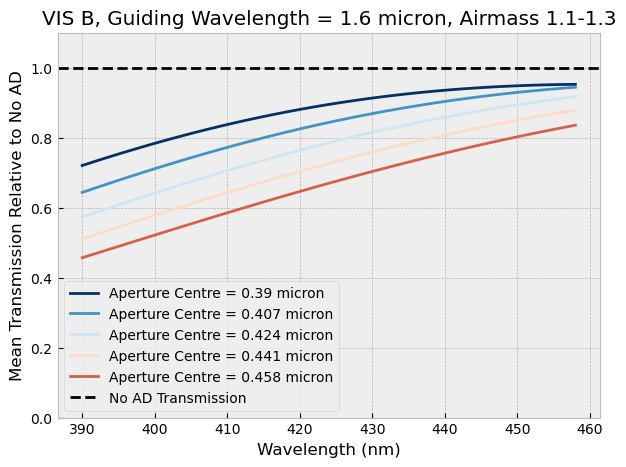

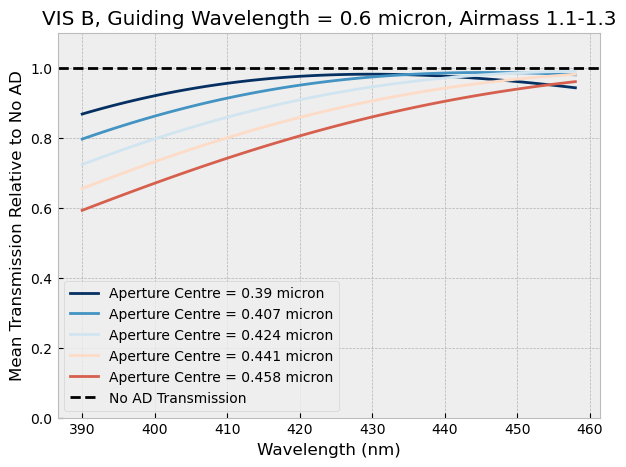

In [44]:
analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','B')
analysis.output_parameters['airmasses']=np.linspace(1.1,1.3,21)
fibres=np.around(np.linspace(min(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,max(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,5)*u.micron,3)
guide=1.6 * u.micron
plot_integ_trans(fibres,guide,analysis,method="numerical moffat",normalise="no AD")

guide=.6 * u.micron
plot_integ_trans(fibres,guide,analysis,method="numerical moffat",normalise="no AD")


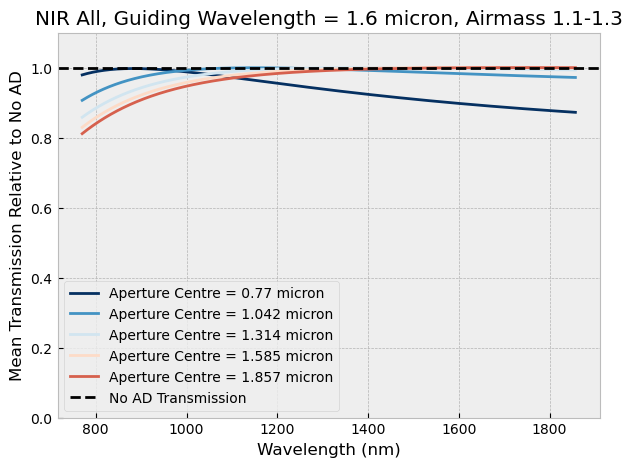

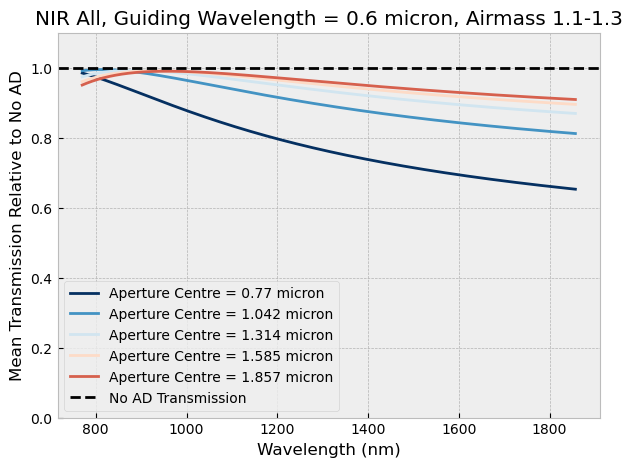

In [45]:
analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H')
analysis.output_parameters['airmasses']=np.linspace(1.1,1.3,21)
fibres=np.around(np.linspace(min(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,max(analysis.output_parameters['wave_wavelengths']).to(u.micron).value,5)*u.micron,3)
guide=1.6 * u.micron
plot_integ_trans(fibres,guide,analysis,method="numerical moffat",normalise="no AD")

guide=.6 * u.micron
plot_integ_trans(fibres,guide,analysis,method="numerical moffat",normalise="no AD")

## Parallel Mode Graph

In [105]:
def plot_integ_trans_parallel(VIS_fibres,NIR_fibres,VIS_mode,NIR_mode,guide,analysis,normalise="none",method="numerical moffat"):  
    weights_r = np.arange(0, len(NIR_fibres)+2)
    norm_r = mpl.colors.Normalize(vmin=min(weights_r), vmax=max(weights_r))
    cmap_red = mpl.cm.ScalarMappable(norm=norm_r, cmap=mpl.cm.Reds)
    weights_b = np.arange(0, len(VIS_fibres)+2)
    norm_b = mpl.colors.Normalize(vmin=min(weights_b), vmax=max(weights_b))
    cmap_blue = mpl.cm.ScalarMappable(norm=norm_b, cmap=mpl.cm.Blues)
    
    analysis.load_wave(VIS_mode[0],VIS_mode[1],VIS_mode[2],VIS_mode[3])
    plt.figure(figsize=[7,5])

    integ_transmissions=[]
    for fibre_val in VIS_fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val,reposition=False, guide_waveref=guide)
        analysis.calculate_transmissions(method=method)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
    
    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(method=method)
    opt_transmission=observation_transmission(analysis.output_parameters)

    count=0
    if normalise == "none":
        for i in integ_transmissions:
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(VIS_fibres[count]),color=cmap_blue.to_rgba(len(VIS_fibres)-count))
            count=count+1
    
        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for i in integ_transmissions:
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(VIS_fibres[count]),color=cmap_blue.to_rgba(len(VIS_fibres)-count))
            count=count+1

    analysis.load_wave(NIR_mode[0],NIR_mode[1],NIR_mode[2],NIR_mode[3])

    integ_transmissions=[]
    for fibre_val in NIR_fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val,reposition=False, guide_waveref=guide)
        analysis.calculate_transmissions(method=method)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(method=method)
    opt_transmission=observation_transmission(analysis.output_parameters)

    count=0
    if normalise == "none":
        for i in integ_transmissions:
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i),label='Aperture Centre = {}'.format(NIR_fibres[count]),color=cmap_red.to_rgba(len(NIR_fibres)-count))
            count=count+1
        plt.ylabel("Mean Transmission")        
        plt.plot(analysis.output_parameters['wave_wavelengths'],opt_transmission,label='No AD Transmission',color='black',linestyle='--')
    if normalise == "no AD":
        for i in integ_transmissions:
            plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(NIR_fibres[count]),color=cmap_red.to_rgba(len(NIR_fibres)-count))
            count=count+1
        plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
        
        plt.ylabel("Mean Transmission Relative to No AD")
    plt.ylim(0,1.1)
    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    plt.axvline(x=guide.value*1000,color='black',linewidth=0.7,label='Guiding Wavelength')
    plt.title("VIS {} + NIR {}, Guiding Wavelength = {}, Airmass {}-{}".format(VIS_mode[2],analysis.input_parameters['band'],guide,analysis.output_parameters['HA_range'][0],analysis.output_parameters['HA_range'][-1]))
    plt.legend()

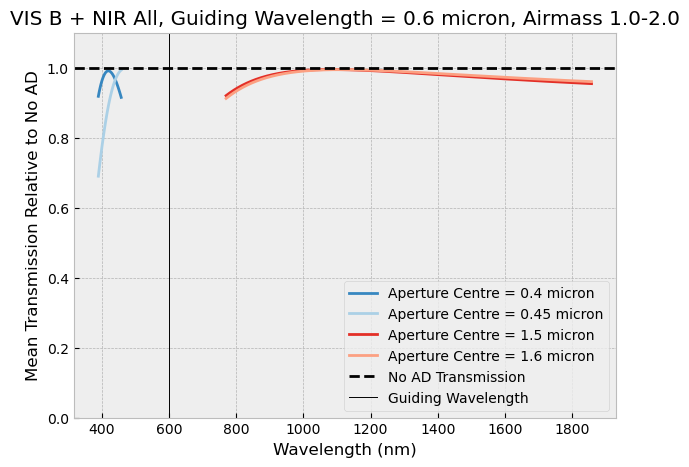

In [107]:
HA=np.linspace(1,2,21)
ZA=atm_diff.HA_2_ZA(HA,0*u.deg)
airmasses=atm_diff.zenith_dist_to_airmass(ZA)

analysis=AD_analysis()
analysis.output_parameters['airmasses']=airmasses
analysis.output_parameters['HA_range']=HA
plot_integ_trans_parallel([0.4]*u.micron,[1.5]*u.micron,["LR","VIS","B","B"],["LR","NIR","IY","H"],.6*u.micron,analysis,normalise="no AD")

Movement of NIR Fibre Centre from Start to End = 0.3031849545848915 arcsec


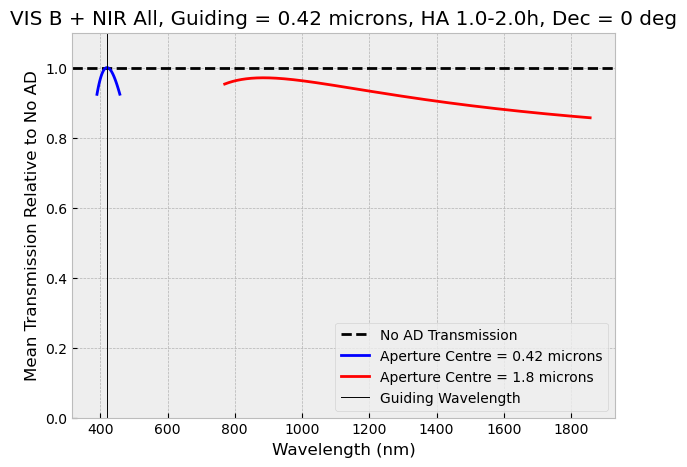

In [ ]:
airmasses=np.linspace(1.1,1.3,21)
weights = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','B',sampling=1 * u.nm)
analysis.output_parameters['airmasses']=airmasses
fibre_min=min(analysis.output_parameters['wave_wavelengths'])
fibre_max=max(analysis.output_parameters['wave_wavelengths'])
fibres=[0.41]
guides=[0.41]

for guide_waveref in guides:
    plt.figure(figsize=[7,5])
    count=0
    integ_transmissions=[]
    for fibre_val in fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val * u.micron,reposition=False, guide_waveref=guide_waveref * u.micron)
        analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
        count=count+1

    plt.ylim(0,1.1)
    plt.ylabel("Mean Transmission Relative to No AD")
    plt.xlabel("Wavelength (nm)")
    plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
    
    plt.title("VIS B + NIR All, Guiding Wavelength = {} microns, Airmass {}-{}".format(guide_waveref,airmasses[0],airmasses[-1]))

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
    opt_transmission=observation_transmission(analysis.output_parameters)
    
    count=0
    for i in integ_transmissions:
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {} microns'.format(fibres[count]),color='blue')
        count=count+1
    plt.legend()
    
airmasses=np.linspace(1.1,1.3,11)
weights = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.output_parameters['airmasses']=airmasses
fibre_min=min(analysis.output_parameters['wave_wavelengths'])
fibre_max=max(analysis.output_parameters['wave_wavelengths'])
fibres=[1.8]
guides=[0.41]

for guide_waveref in guides:
    count=0
    integ_transmissions=[]
    for fibre_val in fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val * u.micron,reposition=False, guide_waveref=guide_waveref * u.micron)
        fibre_index=abs(int((analysis.output_parameters['wave_wavelengths'][0].value-fibre_val*1000)/1)) #sampling = 1
        print("Movement of NIR Fibre Centre from Start to End = {}".format(abs(analysis.output_parameters['shifts'][0][fibre_index]-analysis.output_parameters['shifts'][-1][fibre_index])))
        analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
        count=count+1

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
    opt_transmission=observation_transmission(analysis.output_parameters)

    count=0
    for i in integ_transmissions:
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {} microns'.format(fibres[count]),color='red')
        count=count+1
    plt.legend()

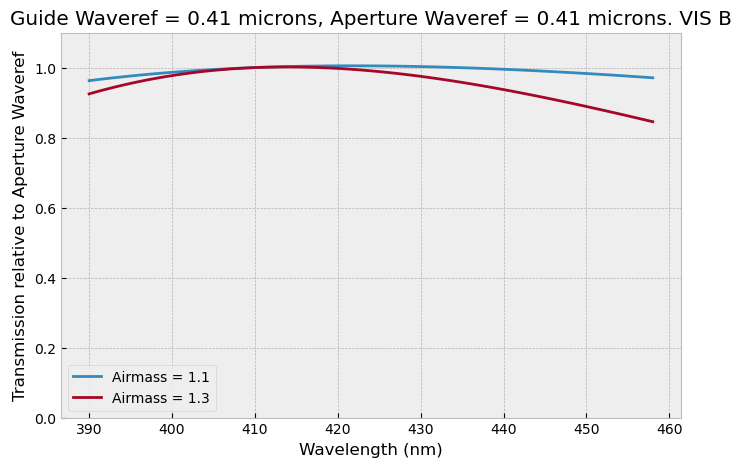

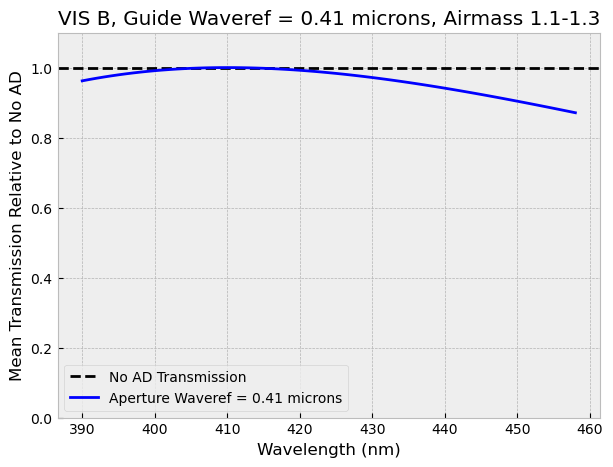

In [6]:
airmasses=np.linspace(1.1,1.3,21)
weights = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

analysis=AD_analysis()
analysis.load_wave('LR','VIS','B','B',sampling=1 * u.nm)
analysis.output_parameters['airmasses']=airmasses
fibre_min=min(analysis.output_parameters['wave_wavelengths'])
fibre_max=max(analysis.output_parameters['wave_wavelengths'])
fibres=[0.41]
guides=[0.41]

for guide_waveref in guides:
    count=0
    integ_transmissions=[]
    for fibre_val in fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val * u.micron,reposition=False, guide_waveref=guide_waveref * u.micron)
        analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
        count=count+1
        plt.figure(figsize=[8,5])
        fibre_index=abs(int((analysis.output_parameters['wave_wavelengths'][0].value-fibre_val*1000)/1)) #sampling = 1
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(analysis.output_parameters['wave_transmissions'][0])/analysis.output_parameters['wave_transmissions'][0][fibre_index],label='Airmass = 1.1')
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(analysis.output_parameters['wave_transmissions'][-1])/analysis.output_parameters['wave_transmissions'][-1][fibre_index],label='Airmass = 1.3')
        plt.ylabel("Transmission relative to Aperture Centre")
        plt.xlabel("Wavelength (nm)")
        plt.ylim(0,1.1)
        plt.legend()
        plt.title("Guide Waveref = 0.41 microns, Aperture Centre = 0.41 microns. VIS B")
        
    plt.figure(figsize=[7,5])
    plt.ylim(0,1.1)
    plt.ylabel("Mean Transmission Relative to No AD")
    plt.xlabel("Wavelength (nm)")
    plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
    
    plt.title("{} {}, Guide Waveref = {} microns, Airmass {}-{}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide_waveref,airmasses[0],airmasses[-1]))

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
    opt_transmission=observation_transmission(analysis.output_parameters)
    
    count=0
    for i in integ_transmissions:
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {} microns'.format(fibres[count]),color='blue')
        count=count+1
    plt.legend()
    

Movement of NIR Fibre Centre from Start to End = 0.4999588231309565 arcsec


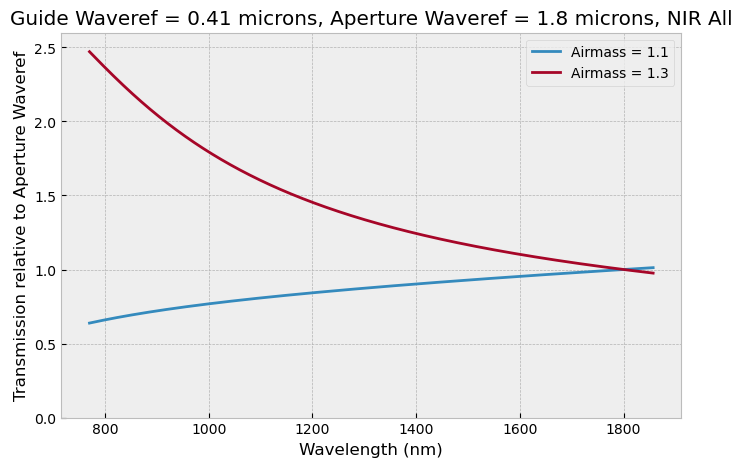

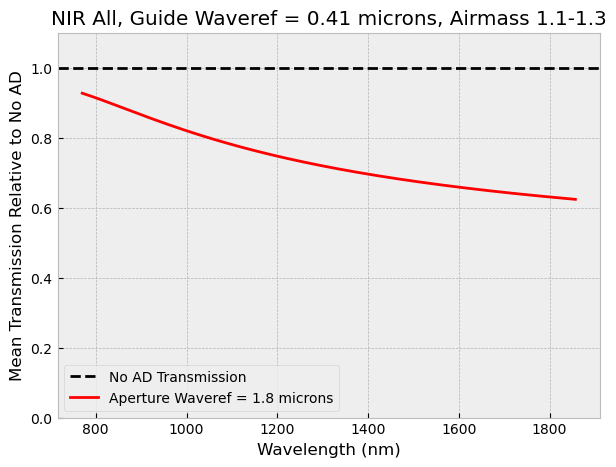

In [7]:
airmasses=np.linspace(1.1,1.3,21)
weights = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.output_parameters['airmasses']=airmasses
fibre_min=min(analysis.output_parameters['wave_wavelengths'])
fibre_max=max(analysis.output_parameters['wave_wavelengths'])
fibres=[1.8]
guides=[0.41]

for guide_waveref in guides:
    
    count=0
    integ_transmissions=[]
    for fibre_val in fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val * u.micron,reposition=False, guide_waveref=guide_waveref * u.micron)
        fibre_index=abs(int((analysis.output_parameters['wave_wavelengths'][0].value-fibre_val*1000)/1)) #sampling = 1
        print("Movement of NIR Fibre Centre from Start to End = {}".format(abs(analysis.output_parameters['shifts'][0][fibre_index]-analysis.output_parameters['shifts'][-1][fibre_index])))
        analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
        plt.figure(figsize=[8,5])
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(analysis.output_parameters['wave_transmissions'][0])/analysis.output_parameters['wave_transmissions'][0][fibre_index],label='Airmass = 1.1')
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(analysis.output_parameters['wave_transmissions'][-1])/analysis.output_parameters['wave_transmissions'][-1][fibre_index],label='Airmass = 1.3')
        plt.ylabel("Transmission relative to Aperture Centre")
        plt.xlabel("Wavelength (nm)")
        plt.ylim(0,2.6)
        plt.legend()
        plt.title("Guide Waveref = 0.41 microns, Aperture Centre = 1.8 microns, NIR All")
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
        count=count+1

    plt.figure(figsize=[7,5])
    plt.ylim(0,1.1)
    plt.ylabel("Mean Transmission Relative to No AD")
    plt.xlabel("Wavelength (nm)")
    plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
    plt.title("{} {}, Guide Waveref = {} microns, Airmass {}-{}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide_waveref,airmasses[0],airmasses[-1]))

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
    opt_transmission=observation_transmission(analysis.output_parameters)
    
    count=0
    for i in integ_transmissions:
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {} microns'.format(fibres[count]),color='red')
        count=count+1
    plt.legend()


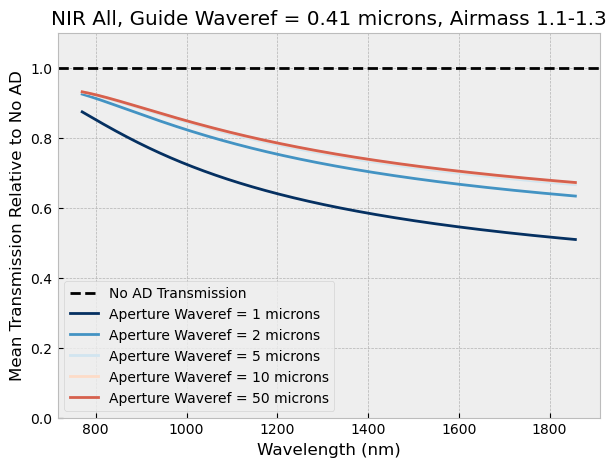

In [8]:
airmasses=np.linspace(1.1,1.3,11)
weights = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.output_parameters['airmasses']=airmasses
fibre_min=min(analysis.output_parameters['wave_wavelengths'])
fibre_max=max(analysis.output_parameters['wave_wavelengths'])
fibres=[1,2,5,10,50]
guides=[0.41]

for guide_waveref in guides:
    
    count=0
    integ_transmissions=[]
    for fibre_val in fibres:
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val * u.micron,reposition=False, guide_waveref=guide_waveref * u.micron)
        analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
        count=count+1

    plt.figure(figsize=[7,5])
    plt.ylim(0,1.1)
    plt.ylabel("Mean Transmission Relative to No AD")
    plt.xlabel("Wavelength (nm)")
    plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
    
    plt.title("{} {}, Guide Waveref = {} microns, Airmass {}-{}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide_waveref,airmasses[0],airmasses[-1]))

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.01)
    opt_transmission=observation_transmission(analysis.output_parameters)
    
    count=0
    for i in integ_transmissions:
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {} microns'.format(fibres[count]),color=cmap.to_rgba(6-count))
        count=count+1
    plt.legend()


Durham Versions of Normalised Graphs

HA used
Target goes below Horizon above/below HA of +/- 8.2h
[1.13169713 1.11291664 1.10675931 1.11291664 1.13169713]
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE


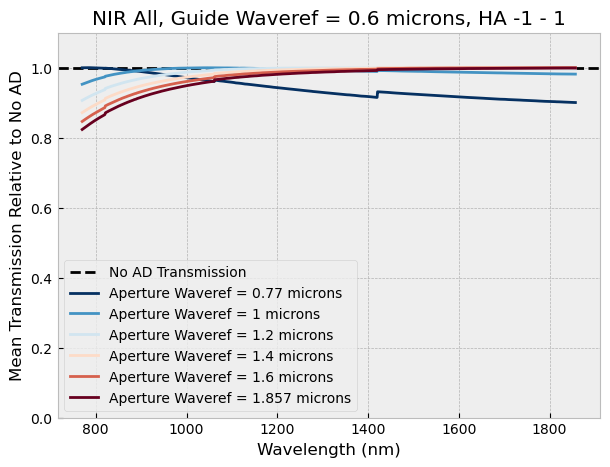

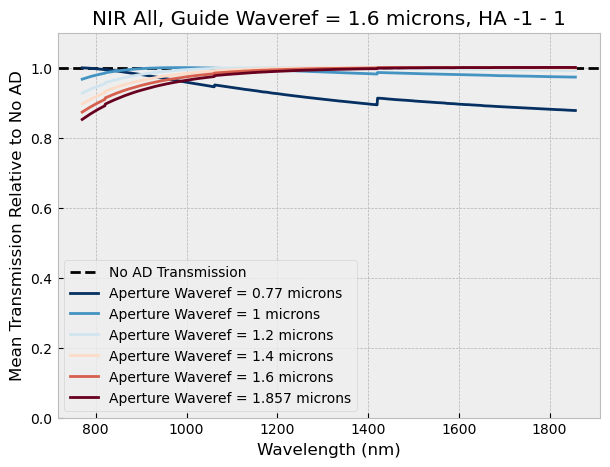

In [11]:
airmasses=np.linspace(1.1,1.3,21)
weights = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

analysis=AD_analysis()
analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm)
analysis.load_airmasses(HA_range=[-1,-0.5,0,0.5,1],targ_dec=-50 * u.degree)
print(analysis.output_parameters['airmasses'])
#analysis.output_parameters['airmasses']=airmasses
fibre_min=min(analysis.output_parameters['wave_wavelengths'])
fibre_max=max(analysis.output_parameters['wave_wavelengths'])
fibres=[fibre_min.to(u.micron).value,1,1.2,1.4,1.6,fibre_max.to(u.micron).value]
guides=[0.6,1.6]


for guide_waveref in guides:
    plt.figure(figsize=[7,5])
    count=0
    integ_transmissions=[]
    for fibre_val in fibres:
        print("NEW FIBRE")
        analysis.calculate_shifts(fibrecentre_waveref = fibre_val * u.micron,reposition=False, guide_waveref=guide_waveref * u.micron)
        analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical durham",scale=0.01)
        integ_transmission=observation_transmission(analysis.output_parameters)
        integ_transmissions.append(integ_transmission)
        count=count+1

    plt.ylim(0,1.1)
    plt.ylabel("Mean Transmission Relative to No AD")
    plt.xlabel("Wavelength (nm)")
    plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
    
    plt.title("{} {}, Guide Waveref = {} microns, HA {} - {}".format(analysis.input_parameters['regime'],analysis.input_parameters['band'],guide_waveref,analysis.input_parameters['HA_range'][0],analysis.input_parameters['HA_range'][-1]))

    for i in range(0,len(analysis.output_parameters['shifts'])):
        for o in range(0,len(analysis.output_parameters['shifts'][i])):
            analysis.output_parameters['shifts'][i][o]=0
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical durham",scale=0.01)
    opt_transmission=observation_transmission(analysis.output_parameters)
    
    count=0
    for i in integ_transmissions:
        plt.plot(analysis.output_parameters['wave_wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {} microns'.format(fibres[count]),color=cmap.to_rgba(6-count))
        count=count+1
    plt.legend()

HA used
Target goes below Horizon above/below HA of +/- 8.2h
[1.10675931 1.13704014 1.14293521 1.14939467 1.15643217 1.16406276]
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE
NEW FIBRE


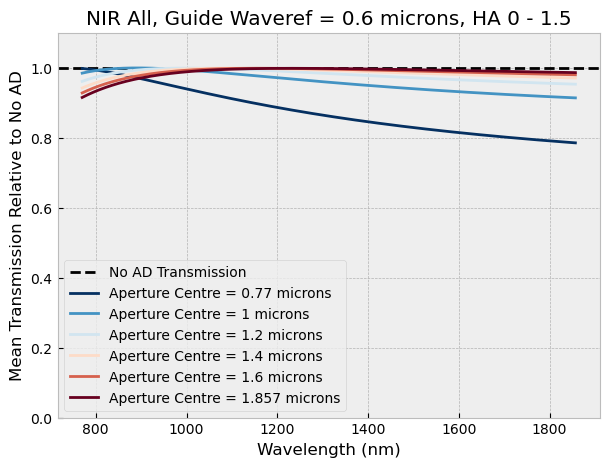

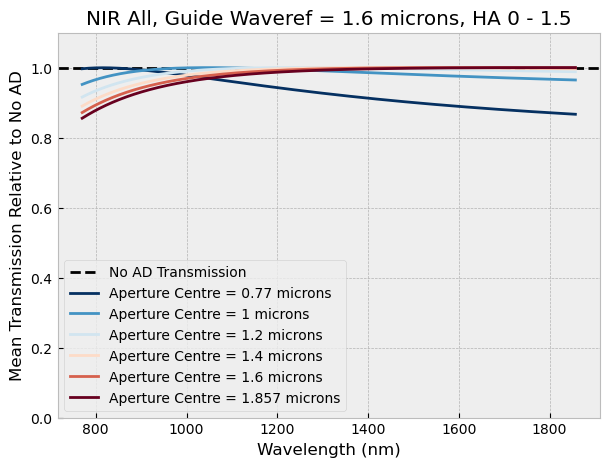

In [12]:
import Transmission_calculation as trans
Plate_Scale = 3.316 # [mm/arcsec]
Plate_Scale = Plate_Scale*1000 #um/arcsec
lambdas=[770,859,1010,1045,1370,1420,1670,1926]*u.nm
shifts_0=[0,0,0,0,0,0,0,0] #is in um
shifts_30=np.array([212,141,60,50,35,42,100,195])
shifts_45=np.array([366,243,104,87,61,72,173,338])
shifts_50=np.array([436,289,124,103,72,86,205,402])
shifts_60=np.array([633,420,179,150,105,125,298,584])
shifts=np.array([shifts_0,shifts_30,shifts_45,shifts_50,shifts_60])/Plate_Scale*u.arcsec


In [13]:
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas
analysis.load_airmasses(ZA_range=[0,30,45,50,60])
analysis.output_parameters['shifts']=shifts
analysis.output_parameters['fibre_diameter']=0.6*u.arcsec
analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)

raw_trans=analysis.output_parameters['wave_transmissions']

ZA_vals=[0,30,45,50,60]
analysis=AD_analysis()
analysis.output_parameters['wave_wavelengths']=lambdas

analysis.output_parameters['shifts']=[shifts_0]*u.arcsec
analysis.output_parameters['fibre_diameter']=0.6*u.arcsec
for i in range(0,len(ZA_vals)):
    analysis.load_airmasses(ZA_range=[ZA_vals[i]])
    analysis.calculate_transmissions(k_lim=30, FWHM_change=True, kolb_factor=True, method="numerical moffat",scale=0.001)
    print("Raw Transmission for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    rounded_vals = [ round(val,3) for val in raw_trans[i]]
    print(rounded_vals)
    normalised_vals=(np.array(raw_trans)[i]/np.array(analysis.output_parameters['wave_transmissions'][0]))
    print("Transmission relative to no AD for ZA = {} for ADC shifts:".format(ZA_vals[i]))
    normalised_vals = [round(elem,3) for elem in normalised_vals]
    print(normalised_vals)
    print("==========================================================")
    

Zenith Angles Used
Zenith Angles Used
Raw Transmission for ZA = 0 for ADC shifts:
[0.425, 0.444, 0.472, 0.478, 0.531, 0.538, 0.572, 0.604]
Transmission relative to no AD for ZA = 0 for ADC shifts:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Zenith Angles Used
Raw Transmission for ZA = 30 for ADC shifts:
[0.369, 0.39, 0.42, 0.426, 0.476, 0.483, 0.514, 0.537]
Transmission relative to no AD for ZA = 30 for ADC shifts:
[0.98, 0.991, 0.998, 0.999, 0.999, 0.999, 0.995, 0.98]
Zenith Angles Used
Raw Transmission for ZA = 45 for ADC shifts:
[0.296, 0.32, 0.351, 0.356, 0.402, 0.408, 0.434, 0.443]
Transmission relative to no AD for ZA = 45 for ADC shifts:
[0.947, 0.975, 0.995, 0.997, 0.998, 0.998, 0.985, 0.943]
Zenith Angles Used
Raw Transmission for ZA = 50 for ADC shifts:
[0.266, 0.29, 0.32, 0.326, 0.369, 0.375, 0.398, 0.4]
Transmission relative to no AD for ZA = 50 for ADC shifts:
[0.93, 0.967, 0.994, 0.996, 0.998, 0.997, 0.98, 0.923]
Zenith Angles Used
Raw Transmission for ZA = 60 for ADC shifts